In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
b = phoebe.load("../estimations/aviles-data-bundle-saves/ebai-estimates")

100%|██████████| 763/763 [01:52<00:00,  6.78it/s]
Wed, 20 Sep 2023 15:56 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


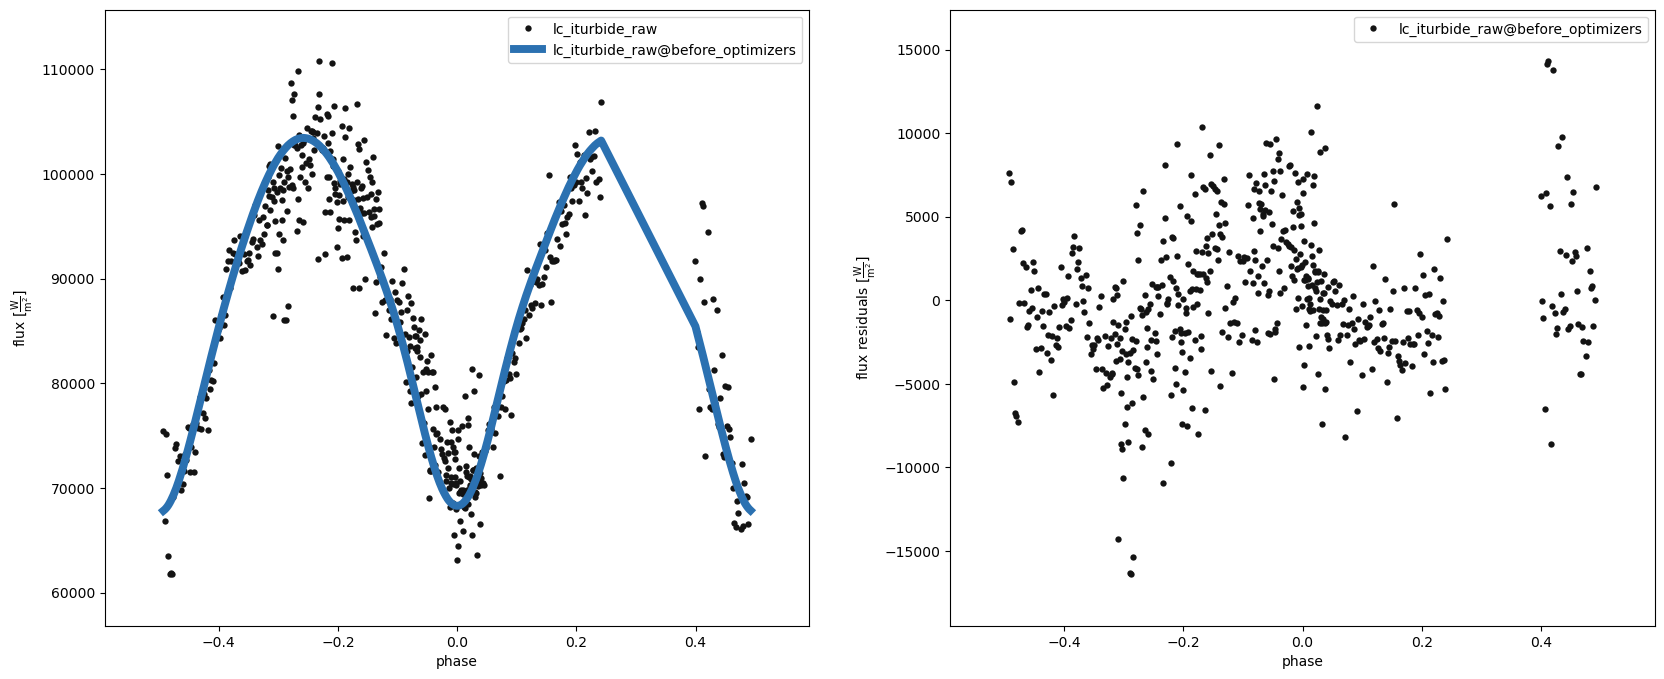

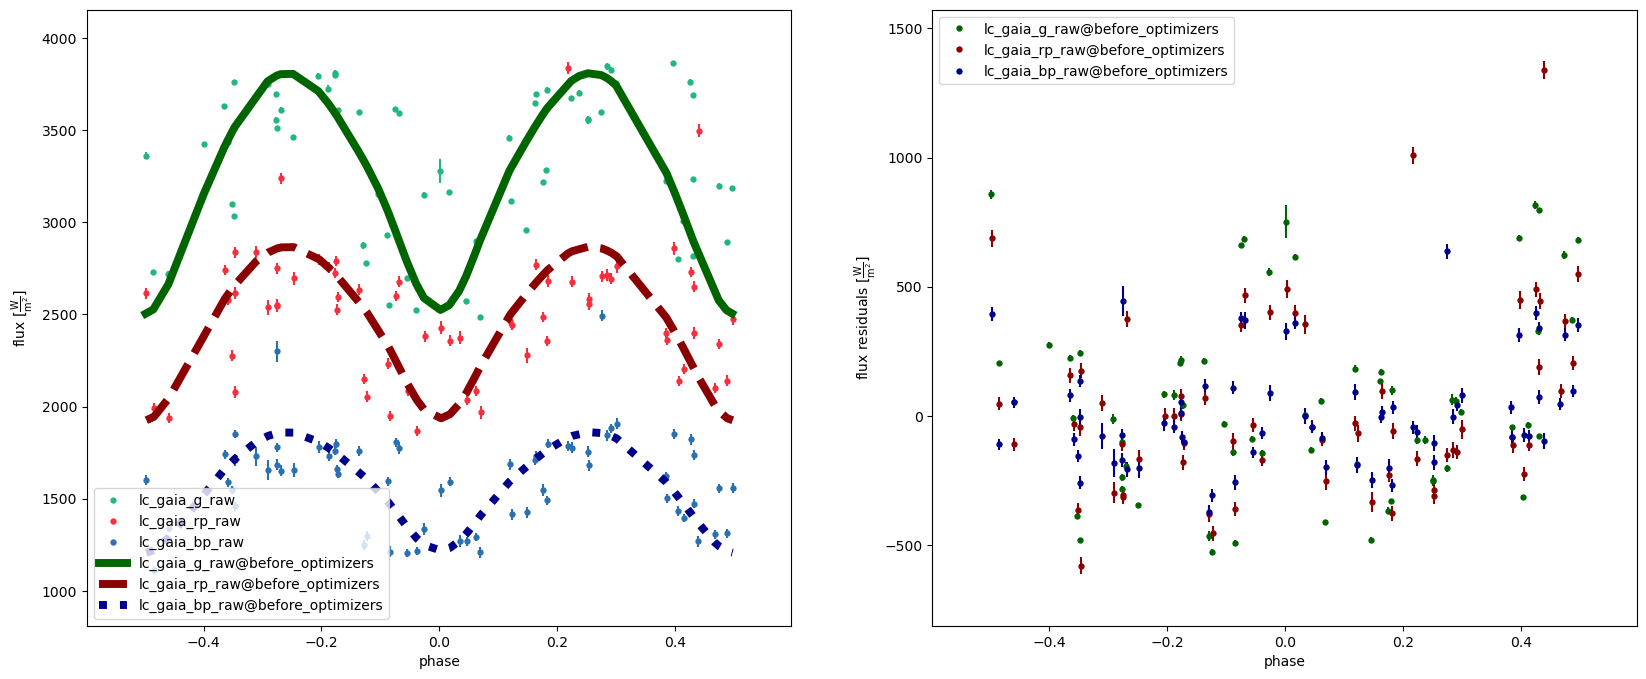

In [3]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers')

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model='before_optimizers', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [4]:
def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	print('\t', "Iturbide -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	for gd in rawGaiaDatasets:
		print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))

In [5]:
printChi2(b, 'before_optimizers')

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496


## Period and `t0_supconj`

In [ ]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, maxiter=200)

Adopted:
t0_supconj@binary@orbit@component = 0.07183 d
period@binary@orbit@component = 0.33354 d

Original values:
  t0_supconj@binary@orbit@component 0.06841024400254482 d
  period@binary@orbit@component 0.3335413827524847 d


100%|██████████| 747/747 [01:41<00:00,  7.37it/s]
Wed, 20 Sep 2023 16:00 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


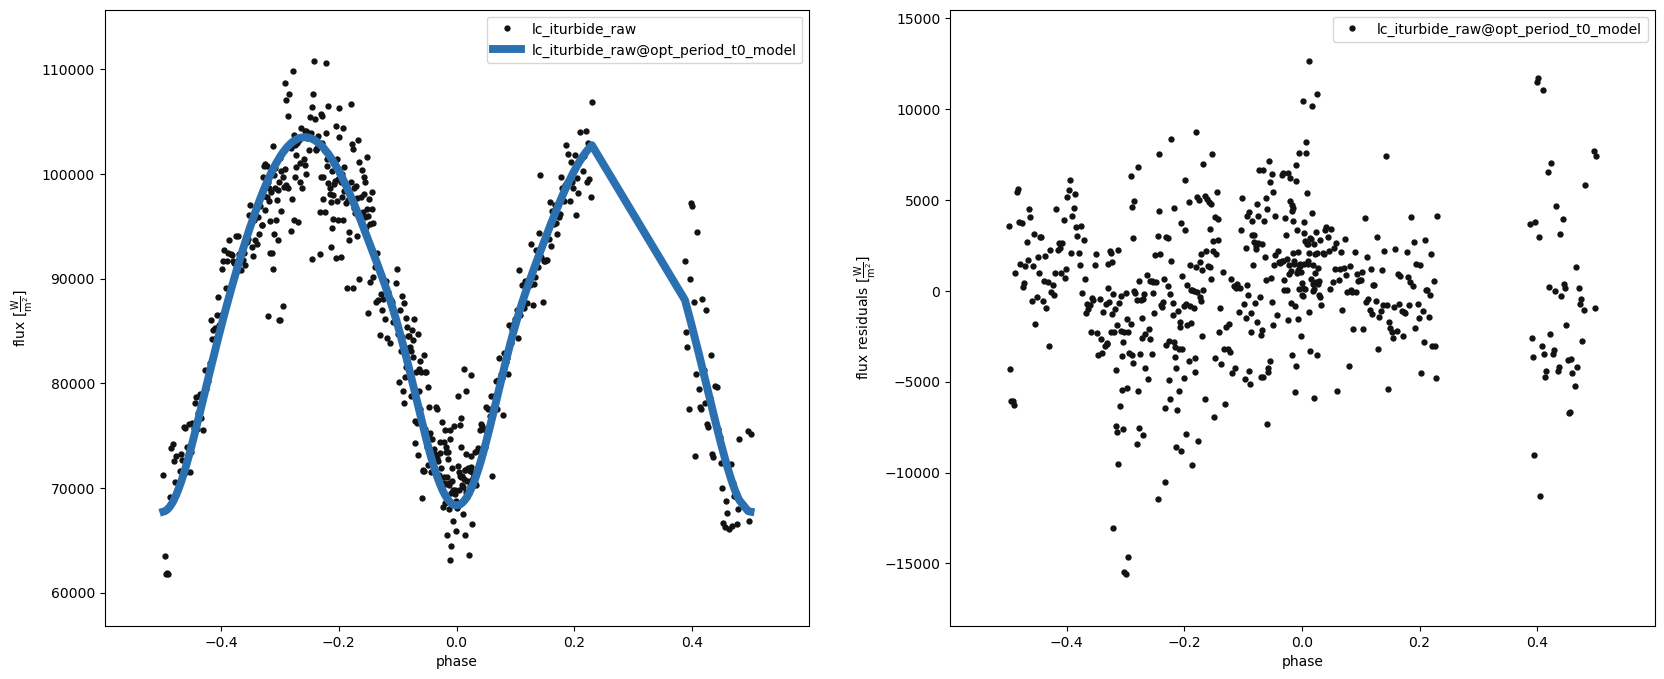

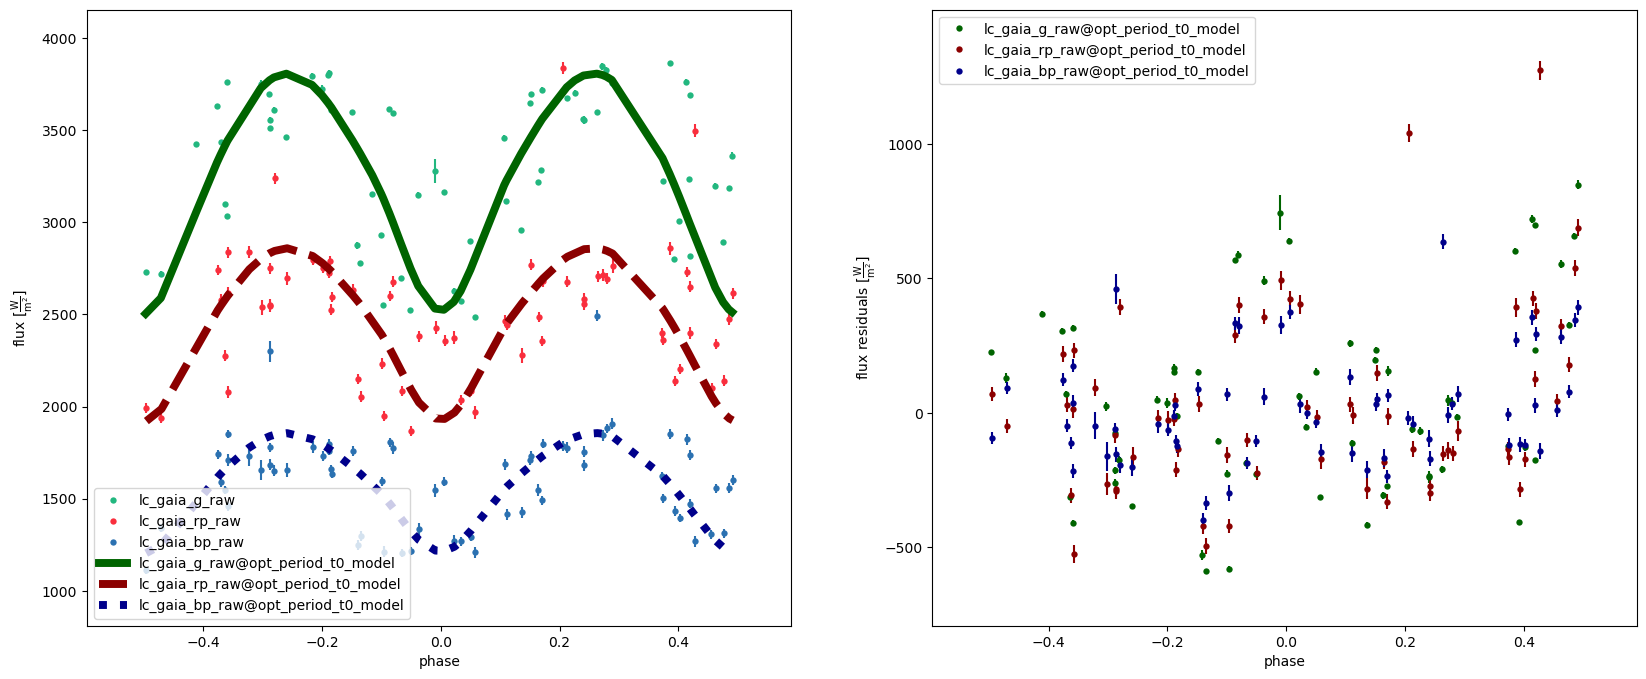

In [7]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./aviles-data-external-jobs/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
# print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [7]:
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

before_optimizers
-------------------------------------
	 Iturbide - 9878882142.08559
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
opt_period_t0_model
-------------------------------------
	 Iturbide - 8396815354.84918
	 Gaia - 77188.51758184715
		 lc_gaia_g_raw - 66206.2342116127
		 lc_gaia_rp_raw - 7463.588528354195
		 lc_gaia_bp_raw - 3518.694841880243


## Width and depth of eclipses

`teffratio`, `fillout_factor`
* Testing out `fillout_factor` for parametrization of the shapes of the stars instead of manipulating their equivalent radii

In [8]:
backup = b.copy()

In [44]:
b = backup.copy()

In [46]:
print(b['requiv'])
print(b['requivsumfrac'])
print(b['requivratio'])
print(b['teffratio'])
print(b['mass'])
print(b['sma@binary'])
print(b['pot'])
print(b['fillout_factor'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.0337700401734613 solRad
C      requiv@secondary@component: 1.7436624098728664 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  requivsumfrac@binary@component: 0.8290843134466649
         requivsumfrac@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component}
ParameterSet: 2 parameters
C    requivratio@binary@component: 1.686702401996762
           requivratio@constraint: {requiv@secondary@component} / {requiv@primary@component}
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                          

### `lc_gaia_g` only

In [56]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_gaiag', 
						  export=True, datasets=['lc_gaia_g_raw'], maxiter=250)

ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_gaiag.py ./results/opt_teffratio_ff_gaiag_solution
('opt_teffratio_ff_gaiag', 'opt_teffratio_ff_gaiag_solution')
ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True


In [12]:
gen_utils.abilitateDatasets(b, allRawDatasets)
print(b['enabled'])

ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: False
   enabled@lc_iturbide@phoebe0...: True
   enabled@lc_iturbide_raw@pho...: False
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: False
   enabled@lc_gaia_rp_raw@phoe...: False
   enabled@lc_gaia_bp_raw@phoe...: False


Adopted:
teffratio@binary@orbit@component = 0.96632 
fillout_factor@contact_envelope@envelope@component = 0.03782 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 763/763 [01:56<00:00,  6.57it/s]
Wed, 20 Sep 2023 16:30 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


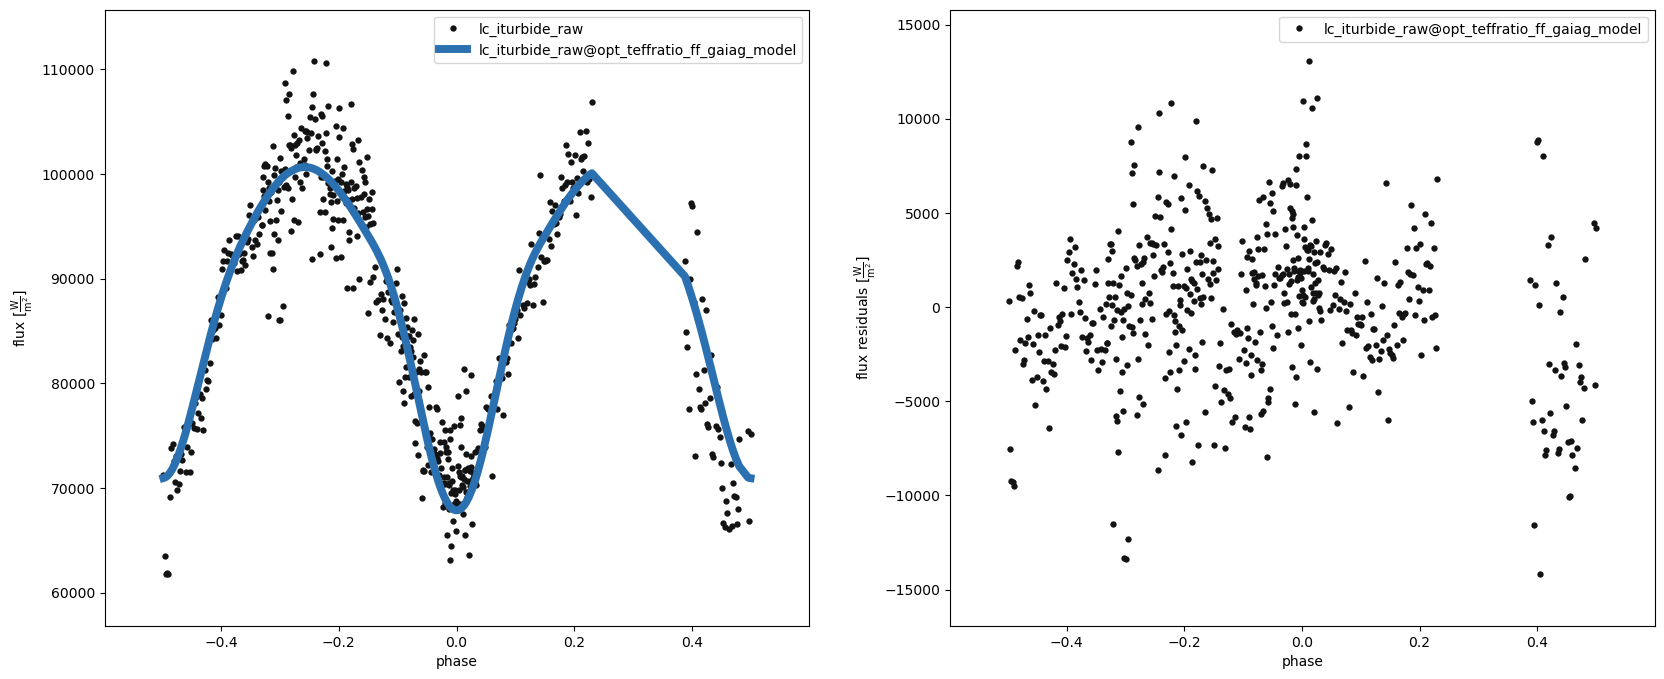

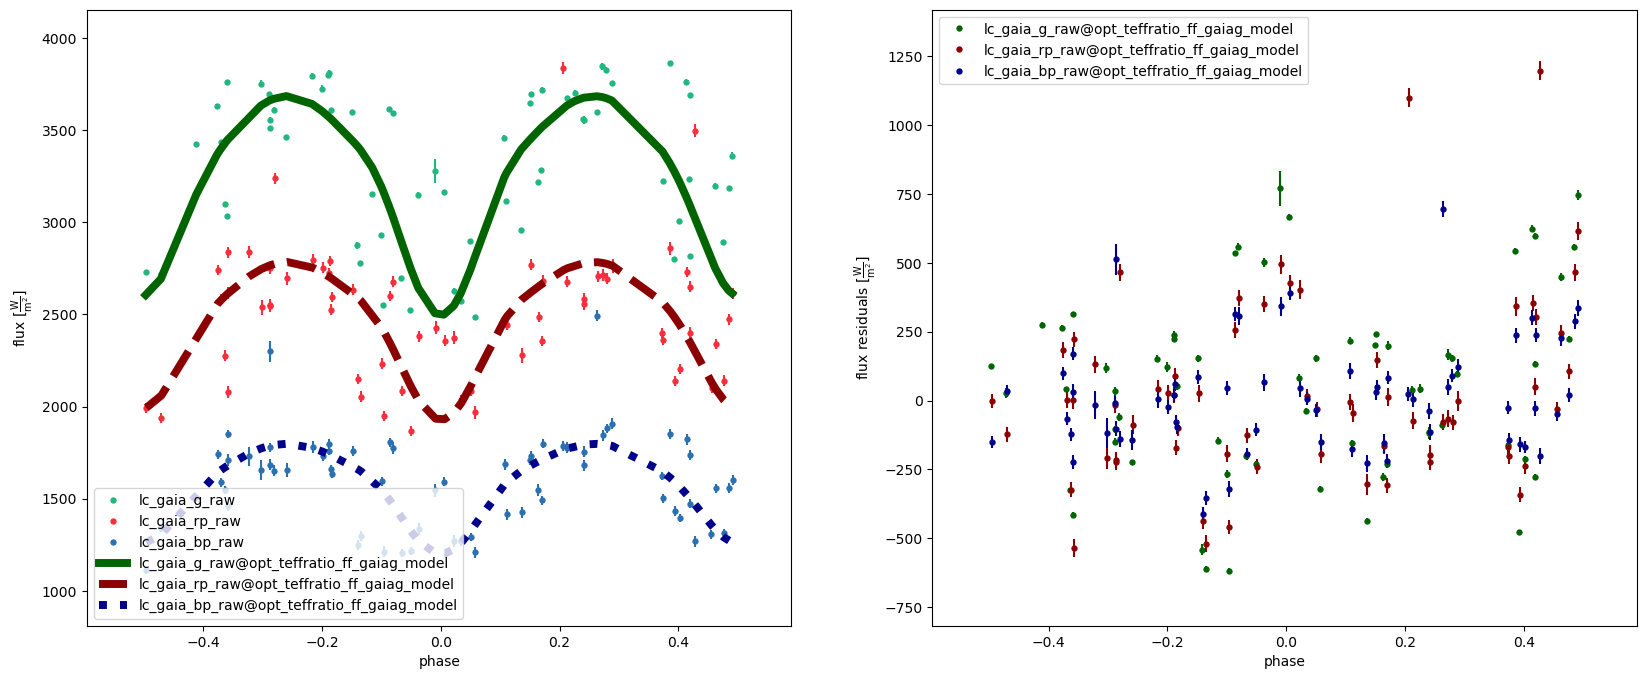

In [13]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_gaiag_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [14]:
keepModels = ['before_optimizers'] + [m for m in b.models if 'opt' in m]
for m in b.models:
	if m not in keepModels:
		b.remove_model(m)
b.models

['before_optimizers', 'opt_period_t0_model', 'opt_teffratio_ff_gaiag_model']

In [15]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837


### `lc_iturbide` only

In [10]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_iturbide', 
						  export=True, datasets=['lc_iturbide_raw'], maxiter=250)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_iturbide.py ./results/opt_teffratio_ff_iturbide_solution


('opt_teffratio_ff_iturbide', 'opt_teffratio_ff_iturbide_solution')

Adopted:
teffratio@binary@orbit@component = 1.02235 
fillout_factor@contact_envelope@envelope@component = 0.33163 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 763/763 [01:36<00:00,  7.94it/s]
Wed, 20 Sep 2023 16:35 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


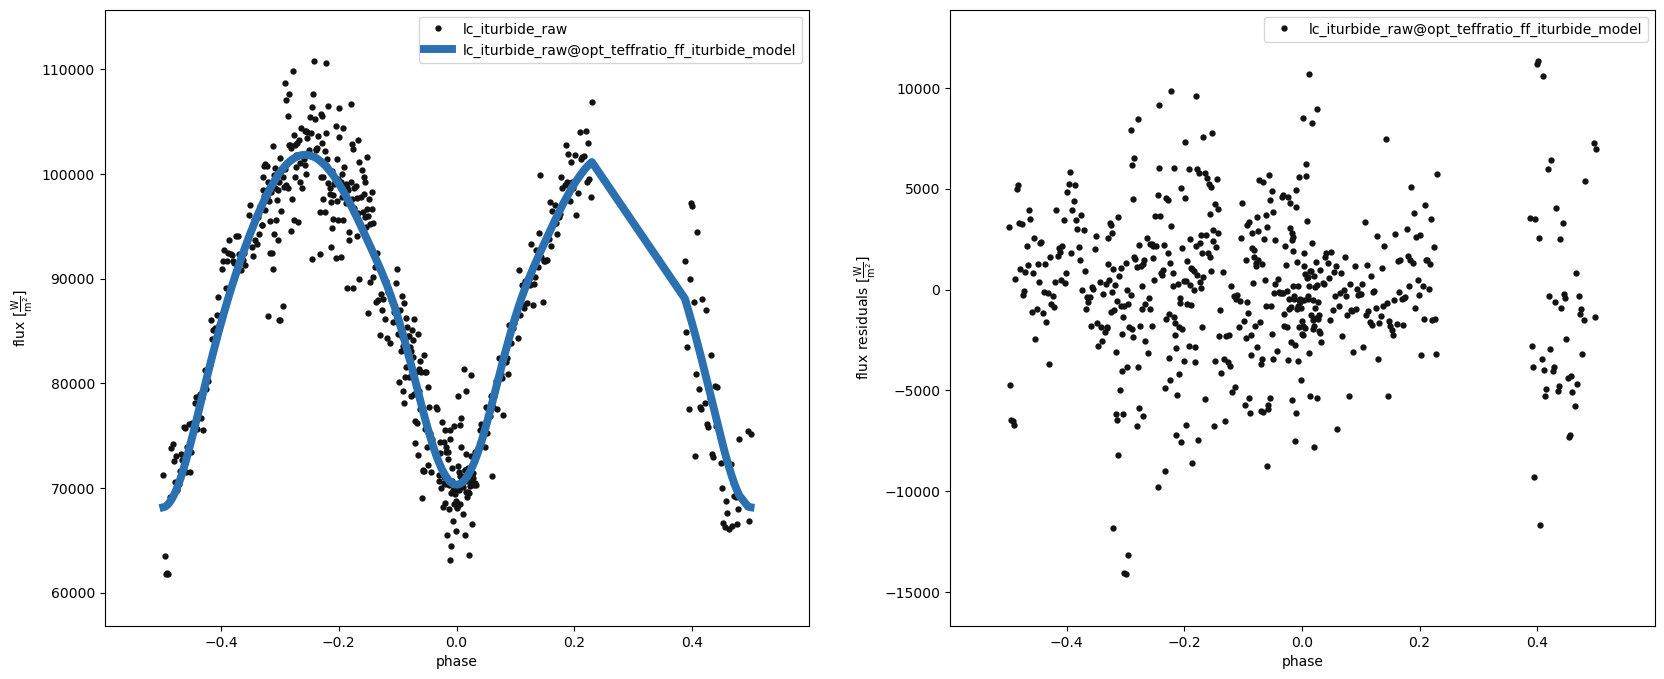

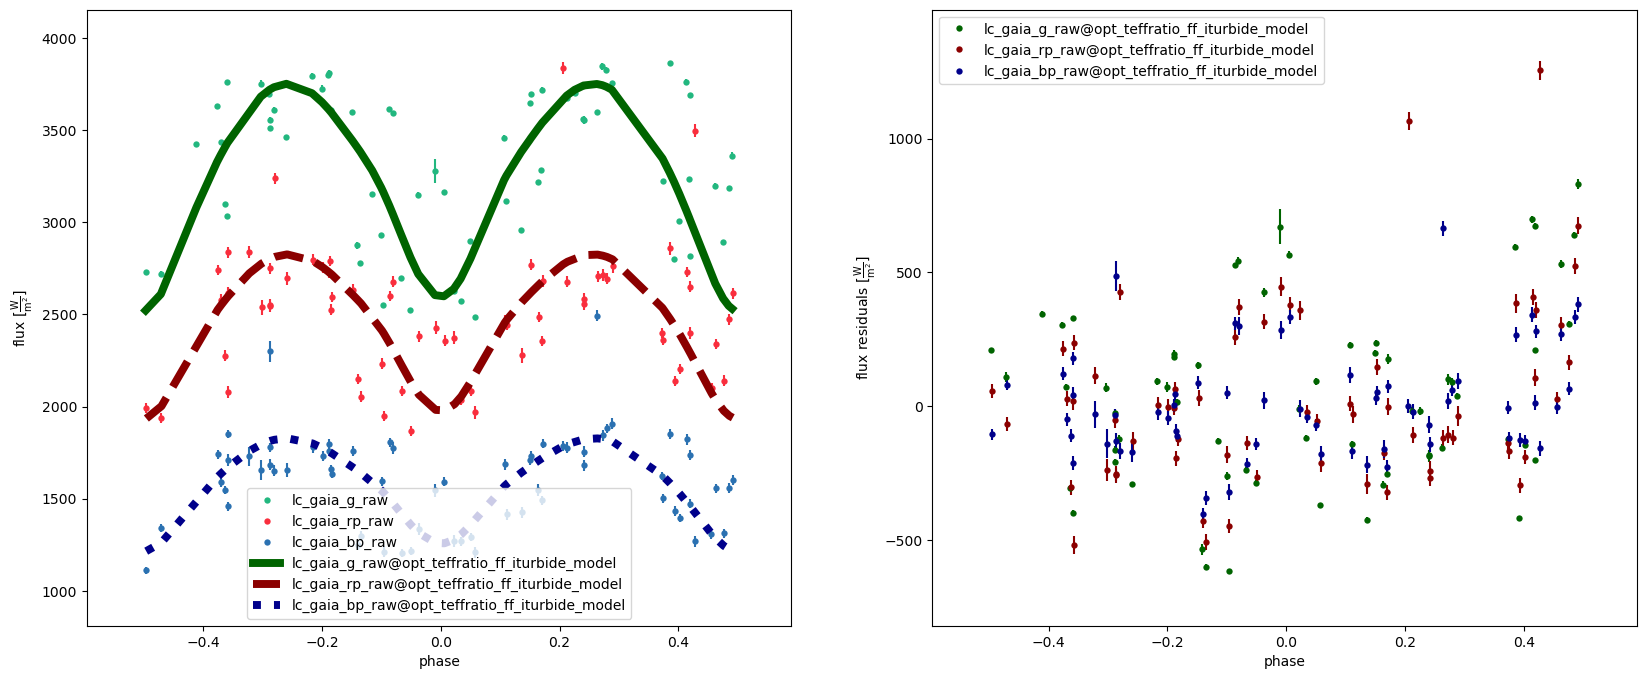

In [16]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_iturbide_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [17]:
for m in b.models:
	printChi2(b, m)

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 7526787405.610246
	 Gaia - 73439.38044855553
		 lc_gaia_g_raw - 62818.554578067226
		 lc_gaia_rp_raw - 7187.746111581734
		 lc_gaia_bp_raw - 3433.0797589065805


In [28]:
print(b['mass'])
print(b['q'], 1/b['value@q'])
print(b['incl@binary'])
print(b['requiv'])
print(b['fillout_factor'])
print(b['pot'])
print(b['teff'])
print(b['sma@binary'])

ParameterSet: 4 parameters
C          mass@primary@component: 1.0087816196188395 solMass
C        mass@secondary@component: 3.525636911085852 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary

### All datasets (Iturbide + Gaia | Raw datasets)

In [57]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_rawdata', 
						  export=True, datasets=allRawDatasets, maxiter=250)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_rawdata.py ./results/opt_teffratio_ff_rawdata_solution


('opt_teffratio_ff_rawdata', 'opt_teffratio_ff_rawdata_solution')

Adopted:
teffratio@binary@orbit@component = 1.02131 
fillout_factor@contact_envelope@envelope@component = 0.32397 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 763/763 [01:35<00:00,  7.96it/s]
Wed, 20 Sep 2023 16:37 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


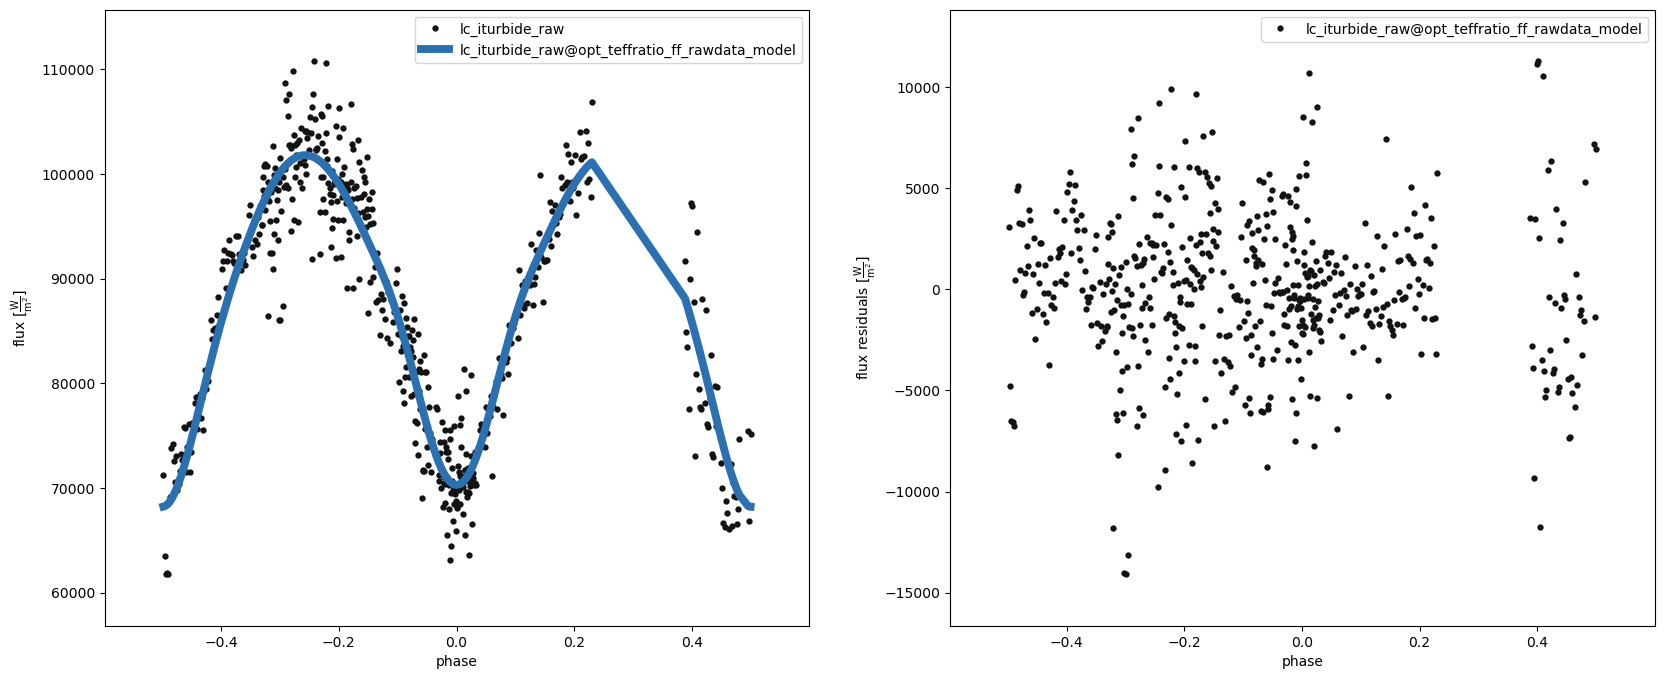

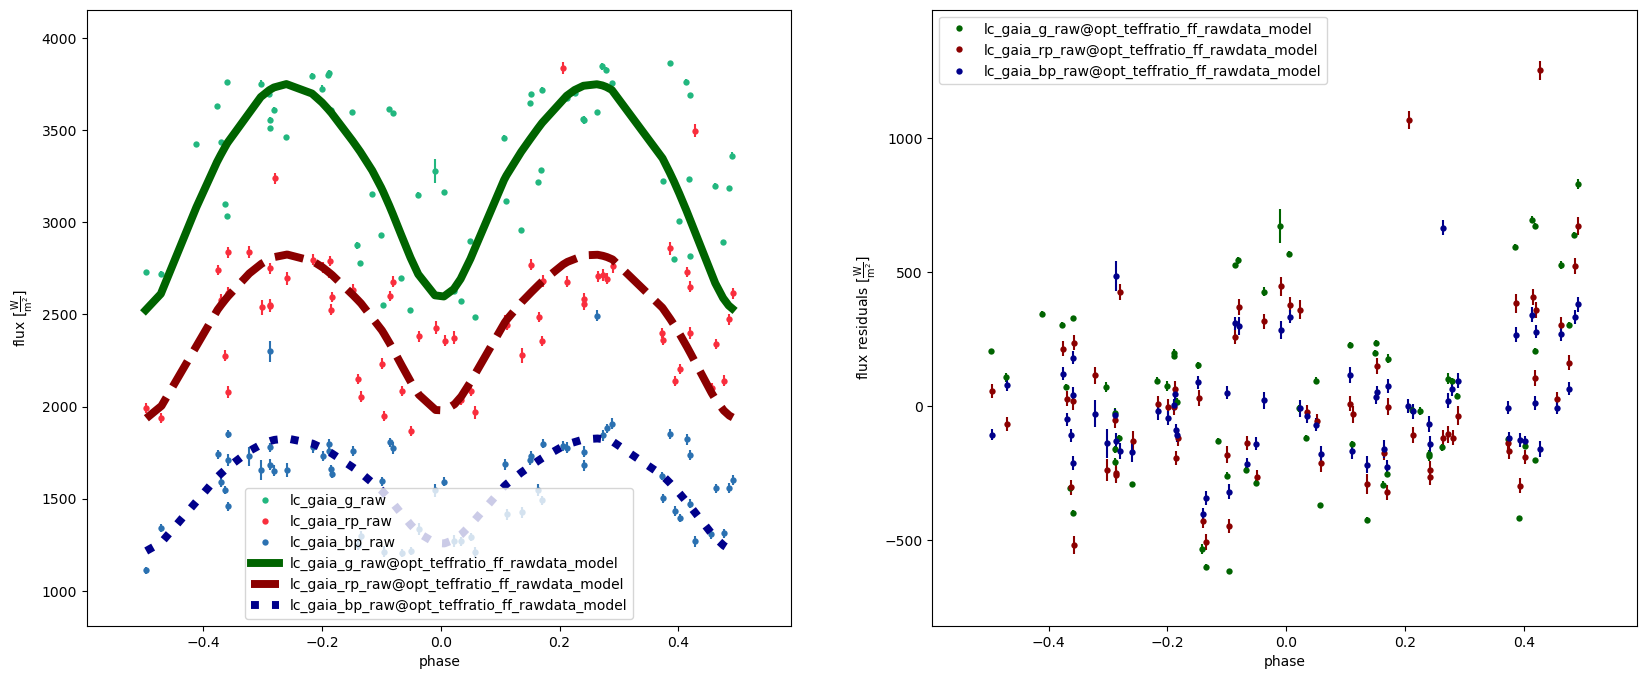

In [18]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_rawdata_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

### Comparing the different solvers

In [19]:
for s in b.solutions:
	if 'opt' not in s:
		b.remove_solution(s)

b.solutions

['opt_period_t0_solution',
 'opt_teffratio_ff_gaiag_solution',
 'opt_teffratio_ff_iturbide_solution',
 'opt_teffratio_ff_rawdata_solution']

In [24]:
print(b['opt_period_t0_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_period_t0@...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
   adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
   adopt_distributions@opt_per...: False
   adopt_values@opt_period_t0@...: True
R  message@opt_period_t0@opt_p...: Maximum number of iterations has been exceeded.
R  niter@opt_period_t0@opt_per...: 150
R  success@opt_period_t0@opt_p...: False
R  initial_values@opt_period_t...: [0.07183033865425345 0.3335413828053897]
R  fitted_values@opt_period_t0...: [0.07183187311538936 0.33354138280951534]
R  fitted_units@opt_period_t0@...: ['d' 'd']
   comments@opt_period_t0@opt_...: 


In [20]:
for m in b.models:
	printChi2(b, m)

print("======================================")

for s in b.solutions:
	print(s, "---------------------------------------", sep='\n')
	gen_utils.printFittedVals(b, s)
	print()

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 7526787405.610246
	 Gaia - 73439.38044855553
		 lc_gaia_g_raw - 62818.554578067226
		 lc_gaia_rp_raw - 7187.746111581734
		 lc_gaia_bp_raw - 3433.0797589065805
opt_teffratio_ff_rawdata_model
--------------------------------